In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import sys
import seaborn as sn

In [2]:
SEED_VALUE = 15

## Task 1: Regression

Both the regression test and train data are loaded using numpy, and a random seed value is set to ensure that the data is shuffled consistently, allowing our results to be replicable when  the function is run several times. The input data is shuffled to remove any preexisting patterns in the dataset that might act as irrelevant predictors of the data. 

In [3]:
np.random.seed(SEED_VALUE)
regression_train_data = np.loadtxt("regression_train.csv", delimiter=',')
regression_test_data = np.loadtxt("regression_test.csv", delimiter=',')
np.random.shuffle(regression_train_data)
np.random.shuffle(regression_test_data)

#### Task 1.1: Linear Regression

In [4]:
def standardize(data, mean=[], sigma=[]):
    if len(mean) == 0:
        mean = np.mean(data, axis=0)
    if len(sigma) == 0:
        sigma = np.std(data, axis=0)
    
    data_std = np.zeros(data.T.shape)
    
    for i in range(data.shape[1]):
        if sigma[i] == 0:
            data_std[i] = data.T[i]
        else:
            data_std[i] = (data.T[i] - mean[i])/ sigma[i]
    
    data_std = data_std.T
#     data_std = (data - mean) / sigma
    return data_std, mean, sigma
    


For this task, we obtain a linear regression model to predict the median value of owner-occupied homes in USD 1000's as your target variable using all the other features as predictors. By using the statistical interpretation of linear regression, we fnid the parameters $\beta_{\text ML}$ that maxmize the likelihood:
$$
p(\mathcal Y | \mathcal X, \boldsymbol\beta) = \prod_{n=1}^N p(y_n | \boldsymbol x_n, \boldsymbol\beta)\,.
$$

These parameters allow us to formulate our regression line, which we then use to predict values given data points from a test set. The accuracy of our model can be calculated using the mean square error.


In [5]:
X_train = regression_train_data[:, :-1]
y_train = regression_train_data[:, -1]
X_test = regression_test_data[:, :-1]
y_test = regression_test_data[:, -1]

# We standardise both the training dataset and the test dataset with the same mean and standard deviation parameters, so that both datasets have predictor features with the same range.
X_train, mean_train, sigma_train = standardize(X_train)
X_test, _, _ = standardize(X_test, mean_train, sigma_train)

print("standard deviation of first column: ", sigma_train[0])
print("First column of X_train", X_train[:5, 0])
print("First column of X_test", X_test[:5, 0])

standard deviation of first column:  0.0
First column of X_train [1. 1. 1. 1. 1.]
First column of X_test [1. 1. 1. 1. 1.]


By inspection of both the test and train dataset, we can see that the first few values of the first column of both X_train and X_test are 1s. The standard deviation of the first column being 0 implies that the first column of both X_train and X_test are filled with 1s. This means that the bias term has been included in the dataset and we do not need to further augment our dataset. 

From our lectures, the maximum likelihood estimator is given by the formula:
$$
\boldsymbol\beta_{\text ML} = (\boldsymbol X^T\boldsymbol X)^{-1}\boldsymbol X^T\boldsymbol y\in\mathbb{R}^D\,.
$$

In [6]:
def max_likelihood_estimate(X, y):
    # resolves the normal equation XT(y - X*beta) = 0
    optimal_beta = np.linalg.solve(X.T @ X, X.T @ y)
    return optimal_beta

In [7]:
def predict_with_estimate(X_test, beta):
    predicted_y = X_test @ beta
    return predicted_y

In [8]:
#calculate the mean square error of the regression line
def mse(y_train, y_predicted):
    n = y_train.shape[0]
    return np.sum(np.square(y_train - y_predicted), axis=0) / n

#### 1.1.1

In [9]:
beta_ml = max_likelihood_estimate(X_train, y_train)
print("The parameters for linear regression, beta_ml is:")
print(beta_ml)

The parameters for linear regression, beta_ml is:
[ 2.30185644e+01 -6.42428261e-01 -7.47418815e+03 -3.98149204e+04
  3.98147514e+04 -4.00063949e+08  9.79120942e+02 -1.63905857e-01
  1.28483429e+03 -9.75994730e+02 -4.91540040e-02 -6.10750434e+03
  7.07828586e-01 -3.68838142e+00  4.00063947e+08  6.10572590e+03
  7.47539451e+03 -1.28838888e+03]


In [10]:
predicted_y_for_training_data = predict_with_estimate(X_train, beta_ml)
in_sample_mse = mse(y_train, predicted_y_for_training_data)
print("In Sample MSE is ", in_sample_mse)

In Sample MSE is  24.374980456628485


In [11]:
predicted_y_for_test_data = predict_with_estimate(X_test, beta_ml)
out_of_sample_mse = mse(y_test, predicted_y_for_test_data)
print("Out of Sample MSE is ", out_of_sample_mse)

Out of Sample MSE is  19.53707302477274


The out of sample MSE of 24.4 is slightly higher as compared to the in sample MSE of 19.6. 
<br>
This is unexpected since models tend to perform better on the training set as compared to the test set. Since our cost function is mean squared error, one reason why our model appears to perform worse on the training set might be due to the larger squared errors from certain data points that are outliers in the data. We plot a graph of squared errors for each input to further investigate this hypothesis.


In [12]:
def squared_error(y_train, y_predicted):
    n = y_train.shape[0]
    return np.square(y_train - y_predicted)

In [13]:
def plot_squared_errors(y_train, y_predicted, title):
    errors = squared_error(y_train, y_predicted)
    plt.figure()
    plt.style.use('seaborn-whitegrid')
    plt.title(title)
    plt.plot(np.arange(len(y_train)), errors, '+', markersize=8)
    plt.xlabel("$i$")
    plt.ylabel("Squared error of $ith$ data point")

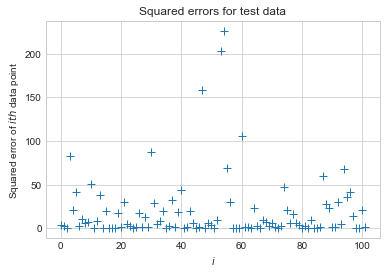

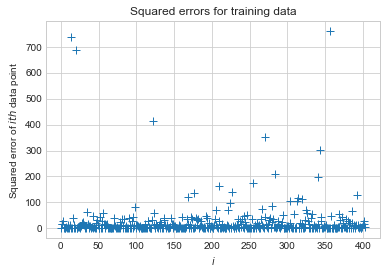

In [14]:
plot_squared_errors(y_test, predicted_y_for_test_data, "Squared errors for test data")
plot_squared_errors(y_train, predicted_y_for_training_data, "Squared errors for training data")

#### 1.1.2
From the graphs, we can observe that for the training data, there are more outliers with significantly higher squared errors with values in the range of 600 - 700. In contrast, the outliers for the test data have squared errors in the range of 150-250. There are also generally more outliers in the training dataset as compared to the test dataset. This might be one of the reasons that contributed to the higher MSE of the training dataset.

### Task 1.2: Ridge Regression

In this task, we use ridge regression to create a model for our dataset. Since we have a hyperparameter, $\lambda$ for ridge regression that controls how much penalty we apply to large values of $\beta$ to keep variance low, we use 5 fold cross validation on the training dataset to find the optimal $\lambda$ for our model. We then find the best estimator for the ridge regression using this $\lambda$. Since our task is regression, MSE is used to calculate the performance of our model

From the lectures, ridge regression is an extension of linear regression with least squares loss function, by including a (usually small) positive penalty term $\lambda$:
$$
\underset{\boldsymbol\beta}{\text{min}} \| \mathcal Y - \mathcal X \boldsymbol\beta \|^2 + \lambda \| \boldsymbol\beta \|^2 = \underset{\boldsymbol\beta}{\text{min}} \ \text{L}_{\text{ridge}} (\boldsymbol\beta)
$$
where $\text{L}_{\text{ridge}}$ is the ridge loss function. The solution is
$$
\boldsymbol\beta^{*}_{\text{ridge}} = (\boldsymbol X^T\boldsymbol X + \lambda I)^{-1}\boldsymbol X^T\boldsymbol y \, .
$$




In [15]:
# shuffles the dataset and splits the dataset into k folds
def split_data(data, num_of_folds=10):
    fold_size = int(data.shape[0] / num_of_folds)
    np.random.seed(SEED_VALUE)
    shuffled_data = np.random.permutation(data)
    return np.array_split(shuffled_data, num_of_folds)
        

To perform cross validation, we split our data set into 5 folds. np.array_split is used to split the dataset into 5 folds, and all data points are divided into the folds. This generates folds of different lengths. I chose not to truncate the last 4 data points to make the folds have equal length, even though the data points lost to truncation would be small. This is because our data set size is relatively small, with 400 data points, and we should consider all the data points when generating models for the dataset.

In [16]:
folds = split_data(regression_train_data, 5)
[print(fold.shape) for fold in folds]

(81, 19)
(81, 19)
(81, 19)
(81, 19)
(80, 19)


[None, None, None, None, None]

In [17]:
# generates the training sets and test sets for each cross validation fold
def generate_test_train_sets(folds, i):
    # drop one fold as test
    cv_test_set = folds[i]
    test_x = cv_test_set[:, : -1]
    #labels for test data
    test_y = cv_test_set[:, -1]

    # use the rest as training data
    cv_train_set = np.vstack([folds[k] for k in range(len(folds)) if k != i])

    train_x = cv_train_set[:, :-1]
    train_y = cv_train_set[:, -1]
    return train_x, train_y, test_x, test_y

In [18]:
# finds beta_ML given penalty term
def ridge_regression_estimate(X, y, penalty):
    R, C = X.shape
    I = np.identity(C)
    beta_ridge = np.linalg.solve(X.T @ X + penalty * I, X.T @ y)
    return beta_ridge
    

In [19]:
#plot penalty parameter against mse
def plot_penalty_param(params_to_errors_map, title):
    plt.scatter(params_to_errors_map.keys(), params_to_errors_map.values(), marker='+')
    plt.title(title)
    plt.xlabel("$\u03BB$")
    plt.ylabel("Mean Square Error")
    plt.show()
        

We perform cross validation across the different folds and obtain graphs of mean square errors against the hyperparameter $\lambda$ for each fold. We then take the fold averaged penalty parameter as our optimal hyperparameter.

In [20]:
# perform cross validation across each fold of thee datsset
def cross_validation_across_each_fold():
    num_of_folds = len(folds)
    #initialise list of penalty terms to try out in cross validation
    penalty_params = np.linspace(0, 20, num=100)

    opt_lambda_in_each_fold = []
    
    # grid of errors for each parameter in each fold
    errors_grid = np.zeros((num_of_folds, len(penalty_params)))
    errors_for_ith_fold = {}
    lowest_error = 0
    
    for i in range(num_of_folds):
        train_x, train_y, test_x, test_y = generate_test_train_sets(folds, i)
        optimal_lambda = None
        min_mse = sys.maxsize
        
        for j, penalty in enumerate(penalty_params):
            #train model using function
            beta_ridge = ridge_regression_estimate(train_x, train_y, penalty)
            
            # use the model to predict values for the validation set and calculate the the corresponding mse
            predicted_y = predict_with_estimate(test_x, beta_ridge)
            # calculate mse on the test set with beta_ridge calculated
            error_validation = mse(test_y, predicted_y)
        
            #add error for the validation set to the grid of errors
            errors_grid[i][j] = error_validation
            # if mse for current lambda < min_mse so far, replace optimal lambda with current lambda
            if min_mse > error_validation:
                min_mse = error_validation
                optimal_lambda = penalty
        
        lowest_error += min_mse
        opt_lambda_in_each_fold.append(optimal_lambda)

    # plot mse against various penalty parameters for each fold
    for i in range(len(errors_grid)):
        param_error_map = {}
        for j in range(len(penalty_params)):
            param_error_map[penalty_params[j]] = errors_grid[i, j]
        plot_penalty_param(param_error_map, "Errors for each \u03BB for Fold " + str(i))
    
    # find average lowest mse across all 5 folds
    lowest_error /= num_of_folds
    # get min lambda for each fold and get the average of these lambda across all 5 folds
    average_optimal_lambda = sum(opt_lambda_in_each_fold) / len(opt_lambda_in_each_fold)
    
    # retrain the ridge regression model on the entire training dataset with the average penalty 
    optimal_beta_ridge = ridge_regression_estimate(X_train, y_train, average_optimal_lambda)
    return average_optimal_lambda, lowest_error, optimal_beta_ridge, opt_lambda_in_each_fold
    

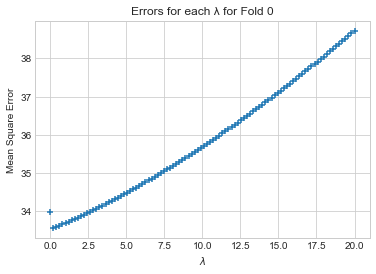

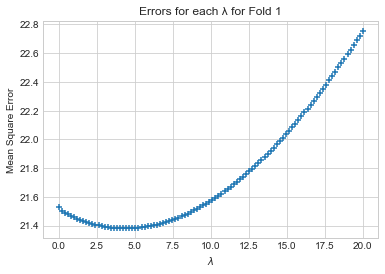

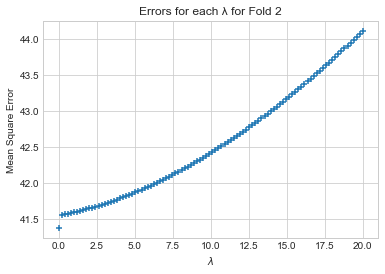

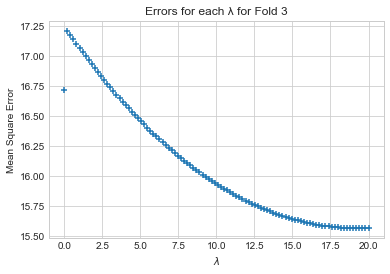

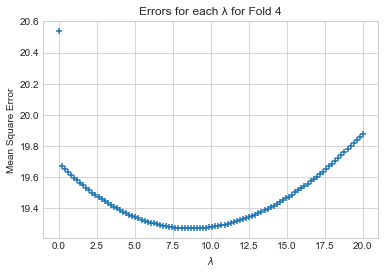

In [21]:
mean_opt_penalty, lowest_error, mean_opt_beta, opt_lambda_per_fold = cross_validation_across_each_fold()

#### 1.2.1

In [23]:
[print(f"Optimal lambda for fold {fold + 1} is {l}""") for fold, l in enumerate(opt_lambda_per_fold)]
print("The mean of all the optimal penalty values is ", mean_opt_penalty)

Optimal lambda for fold 1 is 0.20202020202020202
Optimal lambda for fold 2 is 4.444444444444445
Optimal lambda for fold 3 is 0.0
Optimal lambda for fold 4 is 19.393939393939394
Optimal lambda for fold 5 is 8.686868686868687
The mean of all the optimal penalty values is  6.545454545454545


##### Exploring the performance of the fold averaged cross validation
In the fold averaged cross validation, different lambdas do well on different training datasets, as shown by the plots of penalty terms against errors in different folds. Taking an average of the parameter that gives the lowest mse at each fold would not give an accurate representation of the optimal penalty parameter, since what we want to obtain is a parameter that does consistently well with unseen data by consistently generating models that gives an accurate predicted y value which results in a low mse. Hence, a more accurate estimate of the optimal parameter would be to take the sum of how each penalty parameter performs in each fold and take the average of these errors. In subesequent cross validations, we would be taking the average error or accuracy of each hyperparameter combination across all 5 folds, and taking the hyperparameter combination that gives us the lowest value.

We take the penalty parameter that performs the best by having the lowest average MSE across all 5 folds. We call this the average MSE based cross validation.

In [24]:
def cross_validation_ridge():
    validation_score = defaultdict(float)
    num_of_folds = len(folds)
    penalty_params = np.linspace(0, 20, num=100)
    
    # perform cross validation across k folds
    for i in range(num_of_folds):
        train_x, train_y, test_x, test_y = generate_test_train_sets(folds, i)
        optimal_lambda = None
        min_mse = sys.maxsize
        for j, penalty in enumerate(penalty_params):
            #train model using function
            beta_ridge = ridge_regression_estimate(train_x, train_y, penalty)
            #evaluate model
            predicted_y = predict_with_estimate(test_x, beta_ridge)
            # calculate mse of model and add the mse to the dictionary
            error_validation = mse(test_y, predicted_y)
            validation_score[penalty] += error_validation
    
    #get average MSE for each hyperparameter lambda across all 5 folds
    for param, error in validation_score.items():
        validation_score[param] = error / num_of_folds
    
    #plot graph for the average performance of each hyperparameter
    plot_penalty_param(validation_score, "Average error across all 5 folds")
    
    # find optimal lambda for our model
    optimal_penalty = None
    lowest_error = sys.maxsize
    for param, error in validation_score.items():
        if error < lowest_error:
            optimal_penalty = param
            lowest_error = error
    
    # retrain the ridge regression model on the entire training dataset with the optimal penalty observed
    optimal_beta_ridge = ridge_regression_estimate(X_train, y_train, optimal_penalty)
    return validation_score, optimal_penalty, lowest_error, optimal_beta_ridge
        

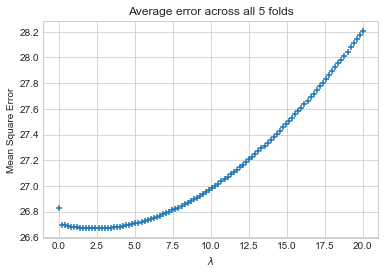

The optimial penalty parameter across all folds is  2.4242424242424243
The average mse is  26.668487647243467


In [25]:
validation_score, param, e, beta_ridge_opt = cross_validation_ridge()
# print(validation_score)
print("The optimial penalty parameter across all folds is ", param)
print("The average mse is ", e)

Again, we evaluate the performance of our ridge regression model by taking the mean square error of our predicted values and the actual values.

In [26]:
def evaluate_ridge_model(X_test, y_test, beta_ridge):
    y_predicted = predict_with_estimate(X_test, beta_ridge)
    error = mse(y_test, y_predicted)
    return error

#### Average based cross validation

In [27]:
error = evaluate_ridge_model(X_train, y_train, beta_ridge_opt)
print(f"The in sample MSE is {error}")

The in sample MSE is 24.574589021414514


In [28]:
e = evaluate_ridge_model(X_test, y_test, beta_ridge_opt)
print(f"The out of sample MSE is {e}")

The out of sample MSE is 19.353333946743277


#### Fold based cross validation

In [29]:
e = evaluate_ridge_model(X_train, y_train, mean_opt_beta)
print(f"The in sample MSE is {e}")

The in sample MSE is 24.699783342933188


In [30]:
e = evaluate_ridge_model(X_test, y_test, mean_opt_beta)
print(f"The in sample MSE is {e}")

The in sample MSE is 19.431430488065356


Although there is not much difference between using either cross validation methods for the MSE, we will use the averaged based cross validation in future cross validation examples since it performs slightly better.

#### 1.2.2
The average in-sample MSE is 24.57 while average out-of-sample MSE is 19.35. Again, out-of-sample MSE is lower than in-sample MSE. Ridge regression has a lower out of sample MSE, but higher in sample MSE compared to linear regression. This higher in sample MSE can be explained by the fact that the ridge regression is optimised with least squares with an additional penalty term, while linear regression is optimised with least squares. The penalty term allows the regression model to have less variance and be more robust to noise and outliers in the training set, hence resulting in a lower out of sample MSE.

### Task 1.3: k nearest neighbours

The kNN algorithm implemented calculates the euclidean distance between the given unseen data point x, to all other points in the training data set. The k closest points to this data point, x, are chosen. Since the distance metric used to select the k closest neighbours is unweighted, the average of the y values for these k neighbours is calculated, forming the predicted value of the data point x. The average of the k nearest points are taken since this is a regression task.

We standardise the datas in both the test and train datasets prevent one feature with large values from overshadowing other features. 

In [31]:
# calculate euclidean distance between two data points
def euclidean_dist(m, n):
    return np.sqrt(np.sum(np.square(m - n), axis=1))

In [32]:
def find_k_nearest_neighbours(x_test, X_train, k):
    # compute distance from x_test to X_train
    dist = euclidean_dist(x_test, X_train)
    enumerated_row = enumerate(dist)
    nearest_neighbours = sorted(enumerated_row, key=lambda x: x[1])[:k]
    
    # return indices of k_nearest_neighbours and euclidean distance sorted by distance
    indices = [neighbour[0] for neighbour in nearest_neighbours]
    dist = [neighbour[1] for neighbour in nearest_neighbours]
    return indices, dist
    

In [33]:
def plot_k_validation(params_to_errors_map, title):
    plt.plot(params_to_errors_map.keys(), params_to_errors_map.values(), marker='+')
    plt.title(title)
    plt.xlabel("$k$")
    plt.ylabel("Mean Square Error")
    plt.show()

In [34]:
def cross_validation_knn():
    validation_score = defaultdict(int)
    num_of_folds = len(folds)
    
    errors_for_last_fold = {}
    
    # perform cross validation across k folds
    for i in range(num_of_folds):
        # drop one fold as test
        train_x, train_y, test_x, test_y = generate_test_train_sets(folds, i)
        params = list(range(1, 25))
        
        for param in params:
            # find k closest neighbours for each data point in test set
            k_nearest_neighbours_of_test_data = [find_k_nearest_neighbours(test, train_x, param) for test in test_x]
            
            # find the average of the values of k closest neighbours for each data point
            predicted_y = np.array([np.average(train_y[neighbours]) for (neighbours, _) in k_nearest_neighbours_of_test_data])
            error_validation = mse(test_y, predicted_y)
            validation_score[param] += error_validation
            
            if i == num_of_folds - 1:
                errors_for_last_fold[param] = error_validation
    
    
    # plot error distribution for last fold
    plot_k_validation(errors_for_last_fold, "MSE of Fold 5 across different k values")
    min_error_fold_5 = min(errors_for_last_fold, key=errors_for_last_fold.get)
    print("Optimal k for fold 5 is", min_error_fold_5)
    #get average MSE for each hyperparam    
    for param, error in validation_score.items():
        validation_score[param] = error / num_of_folds
        
    # find optimal k value across all 5 folds
    optimal_k = None
    lowest_error = sys.maxsize
    for param, error in validation_score.items():
        if error < lowest_error:
            optimal_k = param
            lowest_error = error
            
    return validation_score, optimal_k, lowest_error

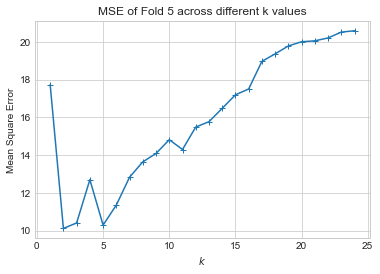

Optimal k for fold 5 is 2
The optimal value for k is 2


In [35]:
validation_score, optimal_k, lowest_error = cross_validation_knn()
print(f"The optimal value for k is {optimal_k}")

#### 1.3.1
In general, the MSE increases as the number of neighbours increases past 5. In addition, the MSE is generally higher at extreme ends (1 and 25). When the number of neighbours considered is 1, the MSE is high because the model is not robust to noise or outliers and is unable to take into account other data points in the vicinity. On the other hand, when the values of k neighbours that are considered becomes very high, we might be considering data points that are irrelevant to the current data point. This is exacerbated by the fact that the distance metric is unweighted and all neighbours are considered equally regardless of their distance to the data point in consideration. Hence, an appropriate number of neighbours, such as 2, 3 or 5 gives a considerably low MSE, with 2 neighbours giving the optimal MSE.

In [36]:
# predict the value of y giveen the training dataset
def knn_predict(X_test,dataset, labels, optimal_k):
    test_neighbours = [find_k_nearest_neighbours(x_test, dataset, optimal_k) for x_test in X_test]
    predicted_y = np.array([np.average(labels[neighbours]) for (neighbours, _) in test_neighbours])
    return predicted_y

In [37]:
test_set_pred = knn_predict(X_test, X_train, y_train, optimal_k)
test_set_accuracy = mse(test_set_pred, y_test)
train_set_pred = knn_predict(X_train, X_train, y_train, optimal_k)
train_set_accuracy = mse(train_set_pred, y_train)
print("test acc: ", test_set_accuracy)
print("train acc: ", train_set_accuracy)

test acc:  13.76362745098039
train acc:  3.970810643564357


#### 1.3.2
A summary table of the out of sample MSE and the in sample MSE for the different models is shown below: 
<br>
<br>

|Table    |In Sample MSE | Out of Sample MSE|
|:-----:|:-----:|:-----: |
|**Linear Regression** |24.37 |19.54 |
|**Ridge Regression**|24.69 |19.54 |
|**K Nearest Neighbours**|3.97|13.76|

The in sample MSE for kNN is much lower than both linear and ridge regression. This is probably due to the fact that the data point itself is considered to be one of the nearest neighbours as the distance to itself is 0. Hence, this causes the predicted value for the data points to be much closer to the actual value.

The kNN model also performs better than both linear and ridge regression for out of sample test data, as shown by its lower MSE. This might be because the kNN algorithm is a local model and is able to give a better prediction when the data itself is not entirely linear separable. The model generalises well to data points that do not "fit" nicely on a linear line, and hence would also be able to better predict the outliers in the dataset that do not follow the pattern of a line. 


## Task 2: Classification

Similar to Task 1, we import the classifiation train and test data, standardise them, and also split the training dataset into 5 different folds for cross validation

In [67]:
np.random.seed(SEED_VALUE)
classification_train_data = np.loadtxt("./classification_train.csv", delimiter=",")
classification_test_data = np.loadtxt("./classification_test.csv", delimiter=",")
train_pd = pd.read_csv("./classification_train.csv")
np.random.shuffle(classification_train_data)
np.random.shuffle(classification_test_data)

In [68]:
classification_train_X = classification_train_data[:, :-1]
classification_train_y = classification_train_data[:, -1]
classification_test_X = classification_test_data[:, :-1]
classification_test_y = classification_test_data[:, -1]

# again, we standardise the data set to allow each feature to have values over similar ranges. This is a good practice.
classification_train_X, mean, sigma = standardize(classification_train_X)
classification_test_X, _, _ = standardize(classification_test_X, mean, sigma)

In [69]:
classification_folds = split_data(classification_train_data, 5)

#### Task 2.1: Logistic Regression

For Logistic Regression, we conduct linear regression on our dataset and pass the predicted values from this linear model through the logistic function. This gives us the probability, p of the data point belonging to a certain class. If p is greater than the decision threshold, we predict the data point to be in class 1. Otherwise, the data point will be in class 0.

The model learns parameters $\boldsymbol \beta$ and $\boldsymbol \beta_0$ and pass the output of this function through the logistic function. The output of this operation is $\hat{\boldsymbol y}_{\text{log}}$:

$$
\hat{\boldsymbol y}_{\text{log}} = f(\boldsymbol X \boldsymbol\beta+ \beta_0)
$$
where $\boldsymbol X = [X^{(1)}, X^{(2)}, \dots, X^{(n)}]$, and $X^{(i)} \in \mathbb R^d$.

$\hat{\boldsymbol y}_{\text{log}}$ gives the probability of the given data point belonging to one of the two classes. A value of 1 is assigned to this data point if the probability is > $\tau$, a decision threshold. Otherwise, this value is 0.

In [41]:
def logistic_fn(x):
    return 1 / (1 + np.exp(-x))

In [42]:
# predicts value of ylog given a test dataset, X, and optimal values of beta and beta_0
def predict_log_reg(X, beta_optimal, beta_0_optimal):
    """
        Obtain the predicted value using beta optimals and pass 
        this outcome through the logistic function.
    """
    y_log = logistic_fn(X @ beta_optimal + beta_0_optimal)
    return y_log

From the lectures, the cost function for logistic regression is 
$$
\mathcal L = - \frac{1}{n} \sum_{i=1}^n y^{(i)} \log(\hat{y}_{\text{log}}^{(i)}) + (1-y^{(i)}) \log (1-\hat{y}_{\text{log}}^{(i)}) \, .
$$

By using gradient descent to optimise the cost function, we take the derivatives with respect to $\boldsymbol \beta$ and $\boldsymbol \beta_0$, giving:

$$
\frac{\partial \mathcal L}{\partial \boldsymbol \beta^{(i)}} = \frac{1}{n} \sum_{i=1}^n (  \hat{y}_{\text{log}}^{(i)} - y^{(i)} ) X^{(i)}
$$
 
$$
\frac{\partial \mathcal L}{\partial \beta_0} = \frac{1}{n} \sum_{i=1}^n ( \hat{y}_{\text{log}}^{(i)} - y^{(i)})
$$

$\boldsymbol \beta$ and $\boldsymbol \beta_0$ are updated using the formulas: 

$$
{\boldsymbol \beta^{(i)}} = {\boldsymbol \beta^{(i-1)}} - \alpha * \frac{\partial \mathcal L}{\partial \boldsymbol \beta}
$$

$$
{\boldsymbol \beta_0^{(i)}} = {\boldsymbol \beta_0^{(i-1)}} - \alpha * \frac{\partial \mathcal L}{\partial \boldsymbol \beta_0}
$$

where $\boldsymbol \alpha$ is the learning rate.

$\boldsymbol \beta$ and $\boldsymbol \beta_0$ are initialised with zeros. Both $\boldsymbol \beta$ and $\boldsymbol \beta_0$ are continuously updated for every iteration.

In [43]:
# given number of features, d, initialise a 1D beta vector with shape (d,) with zeros as values. 
# initialise beta_0 to 0 as well
def initialise(d):
    beta = np.zeros(d, dtype=np.float64)
    beta_0 = 0
    return beta, beta_0

In [44]:
#performs a forward pass on the data by predicting y_log. Returns the loss value, and the derivatives of the loss with respect to  beta and beta_0
def forward(X, y, beta, beta_0):
    n = X.shape[0]
    # predict y_log
    y_predicted = predict_log_reg(X, beta, beta_0)

    # calculate the difference between y_predicted and y_actual
    y_diff = y_predicted - y
    
    # calculate gradients
    grad_beta = (y_diff @ X) / n
    grad_beta_0 = np.sum(y_diff) / n

    # cost function
    cost = (-1) * np.mean(y * np.log(y_predicted) + (1 - y) * np.log(1 - y_predicted), axis=0)
    
    grads = {}
    grads["beta"] = grad_beta
    grads["beta_0"] = grad_beta_0
    return cost, grads

The actual optimisation is conducted by updating $\beta$ and $\beta_0$ with a learning rate ot $\alpha$ using gradient descent for 5000 iterations. The optimal learning rate is obtained through cross validation. The default value is set to 0.01.

In [45]:
def optimise_beta(X, y, beta, beta_0,learning_rate=0.01,num_of_iterations=5000, print_cost=False):
    costs = []
    
    for i in range(num_of_iterations):
        # calculate cost and gradients
        cost, grads = forward(X, y, beta, beta_0)
        
        # update beta
        beta = beta - learning_rate * grads["beta"]
        beta_0 = beta_0 - learning_rate * grads["beta_0"]
        
        #record the cost 
        if i % 500 == 0:
            costs.append(cost)
            if print_cost:
                print("cost after iteration {}: {} ".format(i, cost))

    params = {"beta":beta, "beta_0":beta_0}
    return params, costs

The labels for the test set is predicted after the $\beta$ parameters are calculated.

In [46]:
def predict_class(X, beta, beta_0, decision_threshold=0.5):
    #compute vector y_log that predicts possibilities of data point belonging to class 1
    y_log = predict_log_reg(X, beta, beta_0)
    
    # if y_log > decision threshold, classify data point as 1, otherwise 0
    y_log[y_log > decision_threshold] = 1
    y_log[y_log <= decision_threshold] = 0
    
    return y_log
    

Since the task is classification, we can use accuracy as a metric to determine the performance of our model. Accuracy is calculated using (TP + TN) / (Total number of data points)

In [47]:
def calc_accuracy(y_actual, y_predicted):
    return 1 - np.mean(np.abs(y_predicted - y_actual))

In [48]:
# perform cross_validation on given learning_rate and threshold and returns 
# the average accuracy across all folds
def log_cross_validation(learning_rate, threshold):
    accuracy = 0
    n = len(classification_folds)
    # perform cross validaton across 5 folds
    for i in range(n):
        # initialise beta
        beta, beta_0 = initialise(classification_train_X.shape[1])
        
        train_X, train_y, test_X, test_y = generate_test_train_sets(classification_folds, i)
        # optimise beta using sgd
        params, costs = optimise_beta(train_X, train_y, beta, beta_0, learning_rate)
        
        # predict y_values and calculate accuracy of our model
        y_test_predicted= predict_class(test_X, params["beta"], params["beta_0"], threshold)
        accuracy += calc_accuracy(test_y, y_test_predicted)
    
    average_acc = accuracy / n
    return average_acc

In [49]:
#performs grid search across the various hyperparameter combinations and choose the one giving highest accuracy
def grid_search(grid):
    opt_combi = None
    max_acc = 0
    for combi, acc in grid.items():
        if acc >= max_acc:
            opt_combi = combi
            max_acc = acc
    return opt_combi, max_acc

In [50]:
#finds optimal hyperparameters for logistic regression model
def tune_hyperparameters(learning_rates, thresholds):
    # perform grid search on hyperparameters
    grid = {}
    
    # loop through both parameters to obtain average accuracy for each combination
    for rate in learning_rates:
        for threshold in thresholds:
            # perform cross validation for each learning rate, threshold pair and take the average accurae
            average_accuracy = log_cross_validation(rate, threshold)
            #store resultant accuracy in grid
            grid[(rate, threshold)] = average_accuracy
    
    opt_combi, max_acc = grid_search(grid)
    return opt_combi, grid      

We run the model to obtain the best hyperparameters for our dataset. 
The learning rates are defined as 

In [51]:
def model(X_train, y_train, X_test, y_test, num_of_iterations=5000):
    beta, beta_0 = initialise(X_train.shape[1])
    learning_rate = [0.1, 0.01, 0.02, 0.05, 0.001, 0.002, 0.0001]
    decision_threshold = np.linspace(0.1, 0.9, num=9)
    
    # perform cross validation to obtain the optimal learning rate and decision threshold
    (optimal_learning_rate, optimal_decision_threshold), grid = tune_hyperparameters(learning_rate, decision_threshold)
    print("best learning_rate", optimal_learning_rate)    
    print("best threshold", optimal_decision_threshold)
    
    # train the final classification model over the entire training set using the optimal hyperparameters 
    params, costs = optimise_beta(X_train, y_train, beta, beta_0, optimal_learning_rate,num_of_iterations, print_cost=True)
    
    # predict y_log for the test set and training set
    y_pred_test = predict_class(X_test, params["beta"], params["beta_0"], optimal_decision_threshold)
    y_pred_train = predict_class(X_train, params["beta"], params["beta_0"], optimal_decision_threshold)
    
    # calculate mean accuracies for both the test and train set to determine the performance of our model
    accuracy_test = calc_accuracy(y_test, y_pred_test)
    accuracy_train = calc_accuracy(y_train, y_pred_train)
    print("accuracy of model on test set", accuracy_test)
    print("accuracy of model on train set", accuracy_train)
    return {"costs":costs, "accuracy_grid": grid, 
            "learning_rate":learning_rate, "decision_threshold": decision_threshold}

In [52]:
d = model(classification_train_X, classification_train_y, classification_test_X, classification_test_y)

best learning_rate 0.1
best threshold 0.5
cost after iteration 0: 0.6931471805599452 
cost after iteration 500: 0.5303239866632354 
cost after iteration 1000: 0.5303210871508574 
cost after iteration 1500: 0.530321071766102 
cost after iteration 2000: 0.5303210716655677 
cost after iteration 2500: 0.5303210716649102 
cost after iteration 3000: 0.5303210716649058 
cost after iteration 3500: 0.5303210716649057 
cost after iteration 4000: 0.5303210716649057 
cost after iteration 4500: 0.5303210716649058 
accuracy of model on test set 0.74
accuracy of model on train set 0.745


#### 2.1.2
Compare the performance of your optimal model on the training data and on the test data by
their mean accuracies.

The in sample mean accuracy is 74.5, while the out of sample mean accuracy is 74. The model performs slightly better on the train set than the test set. This is to be expected since the model is fitted on the training set. However, in question 2.2.2, we explore the reasons why accuracy is not the best metric to measure the performance of this model.

### Task 2.2 Random Forest

Random forest is an ensembling method that aggregates and randomisies a list of decision trees to reduce overfitting of the model and to allow our model to become more robust to noise. We create B decision trees to constitute the forest by sampling B samples of size N from our training dataset, with replacement. To build each decision tree, we split the dataset on each feature descriptor and find the feature descriptor that gives us the maximum information gain when we split on that feature. This information gain can be calculated by cross entropy. We continue splitting on other features until all features have been used, or when the maximal depth of the tree has been reached. Each leaf in the tree gives us a probability pair that makes up the probability of that leaf predicting a certain class. We then use the various trees in the forest to predict a value for the test data point and sum up the probabilities across all these trees. The higher probability would dictate the class that the data point is assigned to. There are several hyperparameters that we have to define before we train our model, namely number of trees, depth of tree and the number of features to be chosen as a potential splitting point at each split. The optimal hyperparameters will be chosen again by 5-fold cross validation.

### Cross Entropy loss

The cost function that we want to optimise for random forests is cross entropy. Entropy is defined as the average amount of information of the current state of the dataset. Cross entropy has the formula:

$$
CE[\pi(R_\alpha)] = \sum_{i=1}^n  \pi_n(R_\alpha)log(1 - \pi_n(R_\alpha))
$$
given region $R_\alpha$, across all the classes n


In [53]:
from collections import Counter

# return value of cross entropy using equation above
def cross_entropy(y):
    """ 
    Calculate the cross entropy for labels.
    Arguments:
        y: vector of training labels, of shape (N,).
    Returns:
        (float): the cross entropy for y.
    """
    
    count = Counter(y)
    N = len(y)
    probability = np.zeros(len(count.keys()) + 1)
    
    for label in count.keys():
        probability[int(label)] = count[label] / N
    
    # if the calculated probability is 1, this number is set to a number slightly smaller than 1 to overcome the np.log error
    altered_arr = np.where(probability == 1, 0.9999, probability)
    cross_ent = np.sum(probability * np.log(1 - altered_arr))
    return cross_ent


In [54]:
def split_dataset(X, y, column, value):
    """
    Return the split of data whose column-th feature equals value.
    Arguments:
      X: training features, of shape (N, D).
      y: vector of training labels, of shape (N,).
      column: the column of the feature for splitting.
      value: the value of the column-th feature for splitting.
      sample_weights: weights for each samples, of shape (N,).
    Returns:
      (np.array): the subset of X whose column-th feature equals value.
      (np.array): the subset of y whose column-th feature equals value.
    """ 
    ret = []
    featVec = X[:, column]
    X = X[:,[i for i in range(X.shape[1]) if i!=column]]
    
    # get the indices of rows with column having value equal to value passed in as parameter
    for i in range(len(featVec)):
        if featVec[i]==value:
            ret.append(i)
    
    # returns a subset of X whose column-th feature equals value
    sub_X = X[ret,:]
    sub_y = y[ret]

    return sub_X, sub_y

Information gain is defined as the difference between the initial entropy and the weighted average entropy of the produced subsets. We want to choose the feature that gives us the maximum information gain after the split.

In [55]:
# calculate the information gain by splitting on this feature column
def info_gain(X, y, column):
    """
    Calculate the resulted information gain given a vector of features.
    Arguments:
      X: training features, of shape (N, D).
      y: vector of training labels, of shape (N,).
      column: the column of the feature for calculating. 0 <= column < D
    Returns:
      (float): the resulted info gain after splitting by this feature.
    """

    n = X.shape[0]   
    old_entropy = cross_entropy(y)
    
    unique_vals = np.unique(X[:, column])
    new_entropy = 0.0
    
    #split the values of i-th feature and calculate the cost 
    for value in unique_vals:
        sub_X, sub_y = split_dataset(X, y, column, value) 
        prob = sub_X.shape[0] / n
        new_entropy += prob * cross_entropy(sub_y) 

    ig = old_entropy - new_entropy # information gain
    return ig

In [56]:
def choose_best_feature(X, y, max_no_of_features):
    best_feature_idx = 0
    n_features = X.shape[1]
    
    #select a random subset of features to split at as part of feature bagging
    feature_subset = np.random.permutation(range(n_features))[:max_no_of_features]

    # use C4.5 algorirhm to select best feature to split on from feature subset
    best_gain_cost = 0.0
    for feature in feature_subset:
        info_gain_cost = info_gain(X, y, feature)          
        if info_gain_cost > best_gain_cost:
            best_gain_cost = info_gain_cost
            best_feature_idx = feature              

    return best_feature_idx

In [57]:
def build_tree(X, y, features, depth, max_depth=10, max_no_of_features=4, min_samples_leaf=2):
    mytree = dict()
    # if (i) no feature, (ii) all lables are the same, (iii) depth exceed or (iv) X is too small
    if len(features)==0 or len(np.unique(y))==1 or depth>=max_depth or len(X) <= min_samples_leaf: 
        return probability_label(y)
    else:
        best_feature_index = choose_best_feature(X, y, max_no_of_features)
        features = features[:]
        np.delete(features, best_feature_index)
        
        mytree = {best_feature_index:{}}
        unique_vals = np.unique(X[:, best_feature_index])
        # split on each unique value for the column of the best feature chosen and create a dictionary of decision trees recursively
        for value in unique_vals:
            sub_X, sub_y = split_dataset(X, y, best_feature_index, value)
            mytree[best_feature_index][value] = build_tree(sub_X, sub_y, features, depth+1, max_depth, max_no_of_features)

        return mytree

In [58]:
# returns the label that appears the most in y
labels = np.unique(classification_train_y)
def probability_label(y):
    # returns the number of occurences of each label in y
    count = Counter(y)
    probability_of_returning_label = [count[label] / len(y) for label in labels]
    return probability_of_returning_label

Now, we have all the functions we need to build a decision tree. We can construct a random forest using all the functions from above. Bootstrapping is used to create multiple decision trees. We first produce B random samples from our training dataset. Each sample has size of 800, which is the size of the training dataset. I chose this value since our training dataset is on the lower end of a medium sized dataset and it would be better to have all the data represented when building the decision trees. In additiion, each sample is also stated to have the same size as the original dataset in "Applied Predictive Modeling" by Max Khun and Kjell Johnson.

In [59]:
# produce num_of_trees random samples from S, each of size dataset
def generate_random_samples(X, y, num_of_trees):
    N, _ = X.shape
    forest_dataset = []
    
    # generate N random samples from the dataset with replacement
    for i in range(num_of_trees):
        indices = np.random.choice(N, N)
        sample_X = X[indices]
        sample_y = y[indices]
        forest_dataset.append((sample_X, sample_y))
    return forest_dataset

# generate a random forest with num_of_trees
def random_forest(num_of_trees, max_depth, max_num_of_features, X, y):
    forest_dataset = generate_random_samples(X, y, num_of_trees)
    forest = []
    feature_names = list(range(classification_train_X.shape[1]))
    for tree in forest_dataset:
        X, y = tree
        root = build_tree(X, y, feature_names, 0, max_depth, max_num_of_features)
        forest.append(root)
    return forest

In [60]:
# classify a data point x using the given treee
def classify(tree, x):
    #first element
    feature_name = list(tree.keys())[0]
    second_dit = tree[feature_name]            
    key = x[feature_name]
    if key not in second_dict:
        key = np.random.choice(list(second_dict.keys()))
    value_of_key = second_dict[key]
    if isinstance(value_of_key, dict):
        label = classify(value_of_key, x)
    else:
        label=value_of_key
    return label

# predict the class of a data point x given forest
def rf_predict(forest, x):
    # values at each index represent sum or probabilities from each tree that gave a predicted value of that index
    res = [0, 0]
    
    # sum up the probabilities of the data point being classified as 0 or 1 obtained from each tree
    for tree in forest:
        outcome = classify(tree, x)
        res[0] += outcome[0]
        res[1] += outcome[1]
    
    # return label with max probability
    if res[0] >= res[1]:
        return 0
    return 1

In [61]:
# generate the confusion matrix to evaluate the performance of our model
def rf_confusion_matrix(y_pred, y_actual):
    data = {'y_predicted': y_pred, 'y_actual':y_actual}
    df = pd.DataFrame(data, columns=['y_predicted', 'y_actual'])
    confusion_matrix = pd.crosstab(df['y_actual'], df['y_predicted'], rownames=['Actual'], colnames=['Predicted'])
    return confusion_matrix


In [62]:
def rf_accuracy(y_pred, y_actual):
    n = len(y_actual)
    return 1 - np.mean(np.abs(y_pred - y_actual))

In [63]:

def rf_cross_validation(num_trees, max_depth, max_num_of_features):
    total_acc = 0
    n = len(classification_folds)

    for i in range(n):
        train_X, train_y, test_X, test_y = generate_test_train_sets(classification_folds, i)
        
        #train a forest based on the hyperparameters given 
        forest = random_forest(num_trees, max_depth, max_num_of_features, train_X, train_y)
        # predict the class for the data points in the y se
        y_pred_test = np.array([rf_predict(forest, x) for x in test_X])
        # calculate the accuracy of the model
        acc = rf_accuracy(y_pred_test, test_y)
        total_acc += acc
    
    return total_acc / n

# tune hyperparameters of random forest
def rf_tune_hyperparameters(number_of_trees, max_depth, maximum_number_of_features):
    i = len(number_of_trees)
    j = len(max_depth)
    k = len(maximum_number_of_features)
    print("i, {}, j, {}, k, {}".format(i, j, k))
    print("i", number_of_trees)
    print("j", max_depth)
    print("k", maximum_number_of_features)
    grid = {}
    
    # loop through each hyperparameter
    for num_trees in number_of_trees:
        for depth in max_depth:
            for num_of_features in maximum_number_of_features: 
                print("num_trees: {}, depth: {}, features: {}".format(num_trees, depth, num_of_features))
                avg_accuracy = rf_cross_validation(num_trees, depth, num_of_features)
                grid[(num_trees, depth, num_of_features)] = avg_accuracy
    

    chosen_combi, max_acc = grid_search(grid)
    
    t, d, f = chosen_combi
    print("max_accuracy: ", max_acc)
    print("num_trees: {}, depth: {}, features: {}".format(t, d, f))
    
    return chosen_combi, grid

In [275]:
# train hyperparamters of random forest
trees = list(range(5, 16))
depths = list(range(3, 11))
features = list(range(2, 7))
(opt_num_trees, opt_depth, opt_num_features), grid = rf_tune_hyperparameters(trees, depths, features)

i, 11, j, 8, k, 5
i [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
j [3, 4, 5, 6, 7, 8, 9, 10]
k [2, 3, 4, 5, 6]
num_trees: 5, depth: 3, features: 2
num_trees: 5, depth: 3, features: 3
num_trees: 5, depth: 3, features: 4
num_trees: 5, depth: 3, features: 5
num_trees: 5, depth: 3, features: 6
num_trees: 5, depth: 4, features: 2
num_trees: 5, depth: 4, features: 3
num_trees: 5, depth: 4, features: 4
num_trees: 5, depth: 4, features: 5
num_trees: 5, depth: 4, features: 6
num_trees: 5, depth: 5, features: 2
num_trees: 5, depth: 5, features: 3
num_trees: 5, depth: 5, features: 4
num_trees: 5, depth: 5, features: 5
num_trees: 5, depth: 5, features: 6
num_trees: 5, depth: 6, features: 2
num_trees: 5, depth: 6, features: 3
num_trees: 5, depth: 6, features: 4
num_trees: 5, depth: 6, features: 5
num_trees: 5, depth: 6, features: 6
num_trees: 5, depth: 7, features: 2
num_trees: 5, depth: 7, features: 3
num_trees: 5, depth: 7, features: 4
num_trees: 5, depth: 7, features: 5
num_trees: 5, depth: 7, featur

num_trees: 10, depth: 7, features: 6
num_trees: 10, depth: 8, features: 2
num_trees: 10, depth: 8, features: 3
num_trees: 10, depth: 8, features: 4
num_trees: 10, depth: 8, features: 5
num_trees: 10, depth: 8, features: 6
num_trees: 10, depth: 9, features: 2
num_trees: 10, depth: 9, features: 3
num_trees: 10, depth: 9, features: 4
num_trees: 10, depth: 9, features: 5
num_trees: 10, depth: 9, features: 6
num_trees: 10, depth: 10, features: 2
num_trees: 10, depth: 10, features: 3
num_trees: 10, depth: 10, features: 4
num_trees: 10, depth: 10, features: 5
num_trees: 10, depth: 10, features: 6
num_trees: 11, depth: 3, features: 2
num_trees: 11, depth: 3, features: 3
num_trees: 11, depth: 3, features: 4
num_trees: 11, depth: 3, features: 5
num_trees: 11, depth: 3, features: 6
num_trees: 11, depth: 4, features: 2
num_trees: 11, depth: 4, features: 3
num_trees: 11, depth: 4, features: 4
num_trees: 11, depth: 4, features: 5
num_trees: 11, depth: 4, features: 6
num_trees: 11, depth: 5, features

In [64]:
def rf_model(X, y, X_test, y_test, opt_num_trees, opt_depth, opt_num_features):
    
    print("generating forest")
    forest = random_forest(opt_num_trees, opt_depth, opt_num_features, X, y)

    y_pred_test = np.array([rf_predict(forest, x) for x in X_test])

    confusion_matrix_test = rf_confusion_matrix(y_pred_test, y_test)
    
    X_train = X[:, :-1]
    y_pred_train = np.array([rf_predict(forest, x) for x in X_train])
    
    confusion_matrix_train = rf_confusion_matrix(y_pred_train, y)
    
    plt.figure()
    plt.title("Confusion matrix for training dataset")
    sn.heatmap(confusion_matrix_train, annot=True)
    
    plt.figure()
    plt.title("Confusion matrix for test dataset")
    sn.heatmap(confusion_matrix_test, annot=True)
    
    return confusion_matrix_test, confusion_matrix_train

generating forest


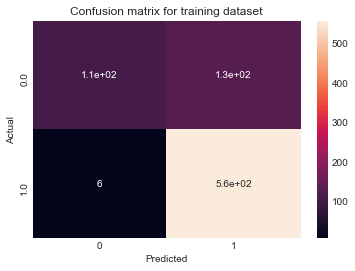

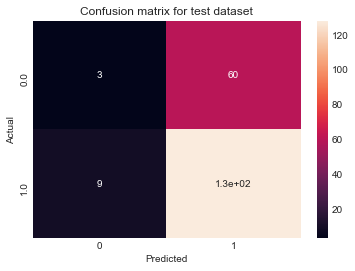

In [321]:
cm_test, cm_train = rf_model(classification_train_X, classification_train_y, classification_test_X, classification_test_y, opt_num_trees, opt_depth, opt_num_features )

In [78]:
# calculates f1 score of the class
def calc_f1(precision, recall):
    if recall == 0 or precision == 0:
        return 0
    return 2 * precision * recall / (precision + recall)
# generate metrics for our model given confusion matrix
def rf_score(confusion_matrix):
    
    unstacked_mat = confusion_matrix.unstack().reorder_levels(('Actual', 'Predicted'))
    #taking 0 to be TP, 1 to be TN
    TP = unstacked_mat.loc[0, 0]
    TN = unstacked_mat.loc[1, 1]
    FP = unstacked_mat.loc[0, 1]
    FN = unstacked_mat.loc[1, 0]
    
    results = {}
    # calculate the precision , recall and f1 score for both classes, 0 and 1
    results["precision_0"] = TP / (TP + FN)
    results["recall_0"] = TP / (TP + FP)
    results["f1_0"] = calc_f1(results["precision_0"], results["recall_0"])
    results["precision_1"] = TN / (TN + FP)
    results["recall_1"] = TN / (TN + FN)
    results["f1_1"] = calc_f1(results["precision_1"], results["recall_1"])

    # calculate the macro average 
    results["macro_avg_f1"] = (results["f1_0"] + results["f1_1"]) / 2
    results["macro_avg_precision"] = (results["precision_0"] + results["precision_1"]) / 2
    results["macro_avg_recall"] = (results["recall_0"] + results["recall_1"]) / 2
    results["accuracy"] = (TP + TN) / (TP + TN + FP + FN)
    
    return results

In [322]:
test_metric = rf_score(cm_test)
train_metric = rf_score(cm_train)
print("Performance metrics for train dataset")
[print(f"{key} : {value}") for key, value in train_metric.items()]
print("**************************")
print("Performance metrics for test dataset")
[print(f"{key} : {value}") for key, value in test_metric.items()]


Performance metrics for train dataset
precision_0 : 0.9469026548672567
recall_0 : 0.45147679324894513
f1_0 : 0.6114285714285714
precision_1 : 0.8107714701601164
recall_1 : 0.9893428063943162
f1_1 : 0.8912
macro_avg_f1 : 0.7513142857142857
macro_avg_precision : 0.8788370625136865
macro_avg_recall : 0.7204097998216307
accuracy : 0.83
**************************
Performance metrics for test dataset
precision_0 : 0.25
recall_0 : 0.047619047619047616
f1_0 : 0.08
precision_1 : 0.6808510638297872
recall_1 : 0.9343065693430657
f1_1 : 0.7876923076923078
macro_avg_f1 : 0.4338461538461539
macro_avg_precision : 0.4654255319148936
macro_avg_recall : 0.49096280848105667
accuracy : 0.655


[None, None, None, None, None, None, None, None, None, None]

In [323]:
training_set_values = Counter(classification_train_y)
print("Number of occurences of each class in the training dataset")
[print(f"Class {i}: {value} values") for i, value in training_set_values.items()]

Number of occurences of each class in the training dataset
Class 1.0: 563 values
Class 0.0: 237 values


[None, None]

#### 2.2.2
The accuracy of our model for our training data is 83%, which is much higher than that for our test dataset, which is 65.5%. 
<br>
Upon inspecting the values in our training dataset, we observe that there are more than double  the number of samples from class 1 (563) than there are class 0 (237). This implies that our dataset is lopsided and hence accuracy is not an accurate representation of the performance of our model since the performance of the class with a higher number of samples will skew the accuracy value. Hence, we look at other metrics, such as precision, recall and f1. These metrics are defined for each class. 
<br>

For Class 1, the summary table of the metrics for both the test and train dataset are as given:
<br>

Class 1 | Train dataset | Test Dataset
:--- | :---: | :---:|
**precision** | 0.81 | 0.68
**recall** | 0.98 | 0.93
**f1** | 0.89 | 0.79

<br>

The model has a high recall value for both test and train datasets. This means that the model is able to correctly recognise data points that belong in class 1. However, the precision of the model for the test dataset is much lower than that of the train dataset, indicating that the model is not very good at differentiating between class 1 and 0, since the proportion of data points labeled as class 1 is indeed class 1 is low in the test set. This is most likely due to the fact that our data is lopsided and we have trained our model to have a bias towards class 1. During bootstrapping, there is a chance that B would contain entirely of data points with labels of 1s, thus affecting the performance of our model. In hindsight, when choosing B samples to construct the random forest, we could restrict our model to choose an equal amount of data points belonging to both classes, thus giving undersampling the majority class to allow our model to perform better. Since the f1 score considers both precision and recall, it is a more accurate metric than accuracy to represent the performance of our model.
<br>
<br>

For Class 0, the summary table of the metrics for both the test and train dataset are as given:

Class 0 | Train dataset | Test Dataset
:--- | :---: | :---:|
**precision** | 0.94 | 0.25
**recall** | 0.45 | 0.04
**f1** | 0.61 | 0.08

<br>
Th model has a low recall value in both train and test datasets, indicating that class 0 is not correctly recognised by our model. In fact, in the test dataset, the recall is close to zero, indicating that our model is not able to recognise data points belonging to class 0 when given unseen data points.  The precision for our training dataset is very high, at 0.94, which indicates that an example labeled as zero is indeed zero. However, this value falls to 0.25 in the test dataset. This is because our model falsely identifies a few data points (9) as 1, and due to the small amount of zeros (3) being correctly classified, the precision is adversely affected. 

<br>
<br>

The macro averaged metrics of both our training and test datasets are as follows:
<br>

Macro Averaged Metrics | Train dataset | Test Dataset
:--- | :---: | :---:|
**precision** | 0.75 | 0.43
**recall** | 0.88 | 0.47
**f1** | 0.72 | 0.49

<br>
The macro averaged statistics takes an average of precision, recall and f1 of both classes. 
Overall, our model performs relatively well on the training dataset, with a f1 score of 0.72. This is to be expected since our model is fitteed to the training dataset. However, due to the model's inability to recognise and classify data points belonging to class 0, our model has a rather mediocre f1 score on the test dataset. 


### Task 2.3 SVM

#### (i) Linear SVM

The cost function, hinge loss for Linear SVM is defined as:
$$
\mathcal L (\boldsymbol w) = \frac{1}{2} \| \boldsymbol w \|^2 + \frac{\lambda}{n} \sum_{i=1}^n \max \bigg( 0, 1-y_i (\boldsymbol w \cdot x_i + b) \bigg) \, 
$$

where $\boldsymbol w$ is the vector of weights, $\lambda$ the regularisation parameter, and $b$ the intercept which is included in our `X` as an additional column of $1$'s.
To implement a hard margin SVM, we want a very large $\lambda$ so that the loss function heavily penalises data points that are on the wrong side of the hyper plane. This allows us to implement a hard margin SVM that tolerates no mistakes.

In [70]:
# add extra column of 1s to both train and test dataset!!! to cater to b
def compute_cost(W, X, y, reg_param=1e100):
    n = X.shape[0]
    
    distances = 1 - y * (np.dot(X, W))
    distances[distances < 0] = 0
    hinge_loss = reg_param * (np.sum(distances) / n)
    
    cost = 1/2 * np.dot(W, W) + hinge_loss
    return cost
    

To perform gradient descent to optimise the weights vector, we need to calculate the gradient of the loss function with respect to the weight vector. The formula is:

$$
\frac{\partial \mathcal L}{\partial \boldsymbol w} = 
\frac{1}{N} \sum_{i=1}^{n}
\left\{\begin{array}{ll}
\boldsymbol{w} & \text { if } \max \left(0,1-y_{i} *\left(\boldsymbol{w} \cdot x_{i}\right)\right)=0 \\
\boldsymbol{w}-\lambda y_{i} x_{i} & \text { otherwise }
\end{array}\right.
$$

In [71]:
def compute_cost_gradient(W, X_batch, y_batch, reg_param=1e100):
    # convert singular data points into a list
    if type(y_batch) == np.float64:
        y_batch = np.asarray([y_batch])
        X_batch = np.asarray([X_batch])
    
    distance = 1 - (y_batch * np.dot(X_batch, W))
    dw = np.zeros(W.shape[0])
    
    for i, d in enumerate(distance):
        if max(0, d) == 0:
            di = W
        else:
            di = W - (reg_param * y_batch[i]* X_batch[i])
        dw += di
    
    #compute average
    dw = dw / len(y_batch)
    return dw

We add an extra column to both train_X and test_X datasets, as well as the weight vector so that the parameter b will be optimised when optimising the weight vector. We perform gradient descent to optimise the weights, with equation:
$$
\boldsymbol w = \boldsymbol w - \alpha \frac{\partial \mathcal L}{\partial \boldsymbol w}
$$
where $\frac{\partial \mathcal L}{\partial \boldsymbol w}$ is the gradient of the hinge loss as we have computed.

In [72]:
def sgd(X, y_train, max_epochs=2000, stop_criterion=0.01, learning_rate=1e-5, reg_param=1e100, print_outcome=False):
    
    #add extra column to X
    X = np.hstack((X, np.ones((X.shape[0], 1))))
    
    # change labels from 0 to -1
    y = np.array(y_train)
    y[y == 0] = -1
    #initialise zero weights
    weights = np.random.rand(X.shape[1]) * 10
    nth = 0
    prev_cost = np.inf
    
    #perform single value stochastic gradient descent
    for epoch in range(max_epochs):
        #shuffle to prevent repeating update cycles
        np.random.shuffle([X, y])
        
        for ind, x in enumerate(X):
            ascent = compute_cost_gradient(weights, x, y[ind], reg_param)
            weights = weights - (learning_rate * ascent)
                                 
        #convergence check on 2^n ith iteration
        if epoch == 2 ** nth or epoch == (max_epochs - 1):
            cost = compute_cost(weights, X, y, reg_param)
            if print_outcome:
                print("ascent: ", ascent)
                print("Current epoch is: {}, Cost is: {}".format(epoch, cost))
            if abs(prev_cost - cost) < stop_criterion * prev_cost:
                return weights
            prev_cost = cost
            nth += 1
    return weights

In [73]:
W = sgd(classification_train_X, classification_train_y, max_epochs=2000, stop_criterion=0.001, learning_rate=1e-3, reg_param=1e100,print_outcome=False)

In [74]:
W

array([-6.80111508e+97, -4.16182645e+96,  6.70469630e+96,  1.79322009e+97,
        3.13880965e+97, -1.36515054e+97,  1.10865353e+97, -2.23396587e+97,
        5.04989568e+97,  2.56909206e+97,  4.77607399e+96,  4.63752371e+97])

In [75]:
def svm_f1_score(y_pred, y_actual, macro=False):
    confusion_matrix = np.zeros(4).reshape((2, 2))
    for i in range(len(y_pred)):
        pred = y_pred[i]
        actual = y_actual[i]
        if pred == -1 and actual == -1:
            # TP
            confusion_matrix[0, 0] += 1
        elif pred == 1 and actual == -1:
            # FN
            confusion_matrix[0, 1] += 1
        elif pred == -1 and actual == 1:
            # FP
            confusion_matrix[1, 0] += 1
        else:
            # TN
            confusion_matrix[1, 1] += 1
    
    TP = confusion_matrix[0, 0]
    TN = confusion_matrix[1, 1]
    FP = confusion_matrix[1, 0]
    FN = confusion_matrix[0, 1]
    
    precision_0 = TP / (TP + FN)
    recall_0 = 0
    if (TP + FP) != 0:
        recall_0 = TP / (TP + FP)
    f1_0 = calc_f1(precision_0, recall_0)
    specificity_0 = TN / (TN + FP)
    
    precision_1 = TN / (TN + FP)
    recall_1 = 0
    if (TN + FN) != 0: 
        recall_1 = TN / (TN + FN)
    specificity_1 = TP / (TP + FN)
    f1_1 = calc_f1(precision_1, recall_1)
    
    macro_avg_f1 = (f1_0 + f1_1) / 2
    macro_avg_precision = (precision_0 + precision_1) / 2
    macro_avg_recall = (recall_0 + recall_1) / 2
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    macro_specificity = (specificity_1 + specificity_0) / 2
    
    if macro:
        return macro_avg_f1, macro_avg_precision, macro_avg_recall, accuracy, macro_specificity
    return f1_1, precision_1, recall_1, accuracy, specificity_1

In [76]:
def score(W, X, y, title, plot_matrix=False, macro=False):
    y_preds = np.array([])
    # change the labels from 0 t0 -1
    y[y == 0] = -1
    X = np.hstack((X, np.ones((X.shape[0], 1))))
    for i in range(X.shape[0]):
        y_pred = np.sign(np.dot(X[i], W))
        y_preds = np.append(y_preds, y_pred)
    
    confusion_matrix = rf_confusion_matrix(y_preds, y)
    if plot_matrix:
        plt.figure()
        plt.title(title)
        sn.heatmap(confusion_matrix, annot=True)
    f1_score, precision, recall, accuracy, _ = svm_f1_score(y_preds, y, macro)
    
    metrics = {"f1_score": f1_score, "precision": precision, "recall": recall, "accuracy":accuracy}
    return metrics

Performance metrics for train dataset
f1_score : 0.6280867699921664
precision : 0.6314949299638015
recall : 0.625728228389621
accuracy : 0.6825
**************************
Performance metrics for test dataset
f1_score : 0.6067036482639195
precision : 0.605433901054339
recall : 0.6083333333333334
accuracy : 0.665


[None, None, None, None]

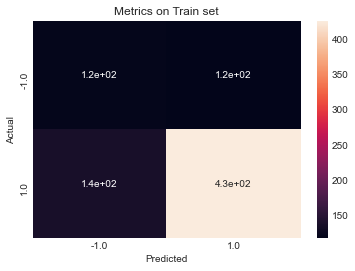

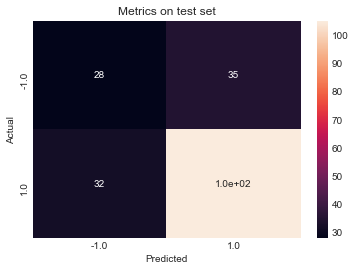

In [80]:
metrics_train = score(W, classification_train_X, classification_train_y, plot_matrix=True, title="Metrics on Train set", macro=True)
metrics_test = score(W, classification_test_X, classification_test_y, title="Metrics on test set", plot_matrix=True, macro=True)
print("Performance metrics for train dataset")
[print(f"{key} : {value}") for key, value in metrics_train.items()]
print("**************************")
print("Performance metrics for test dataset")
[print(f"{key} : {value}") for key, value in metrics_test.items()]

#### (ii) Kernel SVM

The cost function, hinge loss for Linear SVM is defined as:
$$
\mathcal L (\boldsymbol w) = \frac{1}{2} k(w, w) + \frac{\lambda}{n} \sum_{i=1}^n \max \bigg( 0, 1-y_i (k(\boldsymbol w, x_i)) \bigg) \, 
$$
where k is the kerrnel function.

In this case, we us the RBF kernel, given by the equation:
$$
k(x_i, x_j) = e ^ {- \frac{\|{x_i - x_j}\|^2}{2 \sigma^2}}
$$


In [363]:
def euclidean_dist(m, n):
    return np.sqrt(np.sum(np.square(m - n)))

def gaussian(w, X, sigma):
    euclidean_distance = euclidean_dist(X, w)
    exponent = - euclidean_distance / 2 * sigma ** 2
    return np.exp(exponent)

In [364]:
# we compute the hinge loss for the rbf svm by replacing the dot products in linear svm with the kernel function
def compute_cost_rbf(W, X, y, reg_param=1e100, sigma=0.01):
    n = X.shape[0]
    
    distances = 1 - y * (gaussian(W, X, sigma))
    distances[distances < 0] = 0
    hinge_loss = reg_param * np.sum(distances) / n
    
    cost = 1/2 * gaussian(W, W, sigma) + hinge_loss
    return cost

To perform gradient descent to optimise the weights vector, we need to calculate the gradient of the loss function with respect to the weight vector. The formula is:

$$
\frac{\partial \mathcal L}{\partial \boldsymbol w} = 
\frac{1}{N} \sum_{i=1}^{n}
\left\{\begin{array}{ll}
\boldsymbol{w} & \text { if } \max \left(0,1-y_{i} *\left(k (\boldsymbol{w},x_{i})\right) + b\right)=0 \\
\boldsymbol{w}-\lambda y_{i} x_{i} & \text { otherwise }
\end{array}\right.
$$

In [365]:
def compute_cost_gradient_rbf(W, X_batch, y_batch, reg_param=1e100, sigma=0.01):
    # convert singular data points into a list
    if type(y_batch) == np.float64:
        y_batch = np.asarray([y_batch])
        X_batch = np.asarray([X_batch])
    
    distance = 1 - y_batch * (gaussian(W, X_batch, sigma))
    dw = np.zeros(W.shape[0])
    
    for i, d in enumerate(distance):
        if max(0, d) == 0:
            di = W
        else:
            di = W - (reg_param * y_batch[i]* X_batch[i])
        dw += di
    
    #compute average
    dw = dw / len(y_batch)
    
    return dw


In [366]:
def kernel_sgd(X, y, sigma, max_epochs=2000, stop_criterion=0.01, learning_rate=1e-5, reg_param=1e100, print_outcome=False):
    
    # add extra column of 1s to X to predict b
    X = np.hstack((X, np.ones((X.shape[0], 1))))
    
    # change labels from 0 to -1
    y = np.array(y)
    y[y == 0] = -1
    # initialise random weights
    weights = np.random.rand(X.shape[1])
    nth = 0
    # initialise starting cost as infinity
    prev_cost = np.inf

    # stochastic gradient descent
    for iteration in range(1, max_epochs):
        # shuffle to prevent repeating update cycles
        np.random.shuffle([X, y])
        for ind, x in enumerate(X):
            ascent = compute_cost_gradient_rbf(weights, x, y[ind], reg_param, sigma)
            weights = weights - (learning_rate * ascent)

        # convergence check on 2^n'th iteration
        if iteration==2**nth or iteration==max_iterations-1:
            # compute cost
            cost = compute_cost_rbf(weights, X, y, sigma)
            if print_outcome:
                print("Iteration is: {}, Cost is: {}".format(iteration, cost))
            # stop criterion
            if abs(prev_cost - cost) < stop_criterion * prev_cost:
                return weights

            prev_cost = cost
            nth += 1

    return weights

In [385]:
def score_rbf(W, X, y, sigma, title="", plot_matrix=False, macro=False,):
    y_preds = np.array([])
    # change the labels from 0 t0 -1
    y[y == 0] = -1
    
    # extract b from weights to add separately to the prediction
    b = W[-1]
    W = W[:-1]
    for i in range(X.shape[0]):
        y_pred = np.sign(gaussian(W, X[i], sigma) + b)
        y_preds = np.append(y_preds, y_pred)
    
    confusion_matrix = rf_confusion_matrix(y_preds, y)
    if plot_matrix:
        plt.figure()
        plt.title(title)
        sn.heatmap(confusion_matrix, annot=True)
    f1_score, precision, recall, accuracy, TNR = svm_f1_score(y_preds, y, macro)
    
    return f1_score, precision, recall, accuracy, TNR

In [397]:
def cross_validation_rbf(sigma):
    num_of_folds = len(classification_folds)
    
    avg_f1_score = 0
    
    for i in range(num_of_folds):
        train_X, train_y, test_X, test_y = generate_test_train_sets(classification_folds, i)
        
        # perform sgd with weights to get the best W
        W = kernel_sgd(train_X, train_y,max_epochs=2000,stop_criterion=0.01, learning_rate=1e-3, reg_param=1e100, sigma=sigma, print_outcome=False)
        
        # calculate f1 score for data set
        f1, _, _, _, _ = score_rbf(W, test_X, test_y, sigma, macro=True)
        avg_f1_score += f1
    
    return avg_f1_score / num_of_folds

def tune_rbf_hyperparameters():
    sigmas = np.linspace(0.001, 0.1, 100)
    grid = {}
    

    for i, sigma in enumerate(sigmas):
        f1 = cross_validation_rbf(sigma)
        grid[sigma] = f1
    
    
    opt_sigma, max_f1 = grid_search(grid)
    
    print("opt_sigma", opt_sigma)
    print("max_f1: ", max_f1)
    
    return opt_sigma

In [398]:
sigma = tune_rbf_hyperparameters()

opt_sigma 0.1
max_f1:  0.41278348777722995


In [413]:
def rbf_train(X, y, sigma, macro=False):
    W = kernel_sgd(X, y, sigma, max_epochs=2000, stop_criterion=0.001, learning_rate=1e-3, reg_param=1e100)
    f1_train, precision_train, recall_train, accuracy_train, TNR = score_rbf(W, X, y, sigma, plot_matrix=True, title="Confusion Matrix for Train dataset", macro=macro)
    metrics = {"f1_train":f1_train, "precision_train":precision_train, "accuracy_train":accuracy_train, "TNR":TNR, "recall_train":recall_train}
    return W, metrics
    
def rbf_predict(W,X_test, y_test, sigma, plot_matrix=False, macro=False):
    f1, precision, recall, accuracy, TNR = score_rbf(W, X_test, y_test, sigma, plot_matrix=plot_matrix, title="Confusion Matrix for Test dataset", macro=macro)
    metrics = {"f1":f1, "precision":precision, "accuracy":accuracy, "TNR":TNR, "recall":recall}
    return metrics

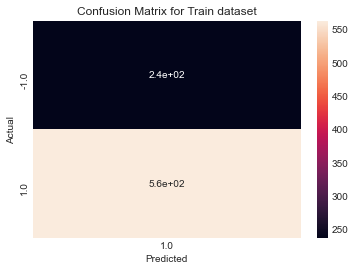

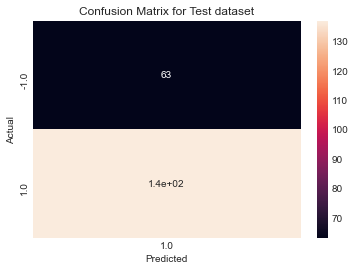

In [414]:
W, train_metrics = rbf_train(classification_train_X, classification_train_y, sigma, macro=True)
test_metrics = rbf_predict(W, classification_test_X, classification_test_y, sigma, plot_matrix=True, macro=True)

In [415]:
print("Performance metrics for train dataset")
[print(f"{key} : {value}") for key, value in train_metrics.items()]
print("**************************")
print("Performance metrics for test dataset")
[print(f"{key} : {value}") for key, value in test_metrics.items()]

Performance metrics for train dataset
f1_train : 0.4130594277329421
precision_train : 0.5
accuracy_train : 0.70375
TNR : 0.5
recall_train : 0.351875
**************************
Performance metrics for test dataset
f1 : 0.4065281899109792
precision : 0.5
accuracy : 0.685
TNR : 0.5
recall : 0.3425


[None, None, None, None, None]

##### 2.3.1
We take the macro averaged statistcs of the linear SVM and the optimal kernel SVM and compare them for both train and test datasets:

For the training dataset:

Performance Metrics | Linear SVM | Kernel SVM
:--- | :---: | :---:|
**precision** | 0.62 | 0.5
**recall** | 0.62 |  0.35
**f1** | 0.62 | 0.5

<br>
Overall, the kernel SVM performs much poorer than the linear SVM on the training set. 
The kernel SVM has a much lower precision than the linear SVM of 0.5. This might be due to the fact that the kernel SVM predicts all ones for the training data points. In fact, the kernel is unable to recognise both classes due to the low macro average recall score. 

<br>
<br>

For the test dataset:

Performance Metrics | Linear SVM | Kernel SVM
:--- | :---: | :---:|
**precision** | 0.65 | 0.5
**recall** | 0.66 | 0.34
**f1** | 0.65 | 0.41

<br>

The kernel SVM also performs much poorer than the linear SVM on the test set.
The same observations for the training set applies here as well.



In [416]:
def plot_ROC_curve(W, X_test, y_test):
    sigmas = np.linspace(0.001, 0.1, 100)
    results = [rbf_predict(W, X_test, y_test, sigma, plot_matrix=False) for sigma in sigmas]
    TPR_vals = [metrics["recall"] for metrics in results]
    TNR_vals = [metrics["TNR"] for metrics in results]
    FPR = [1 - TNR for TNR in TNR_vals]
    
    plt.figure()
    plt.scatter(TPR_vals, TNR_vals)
    plt.title("ROC Curve")
    plt.xlabel("FPR")
    plt.ylabel("TNR")

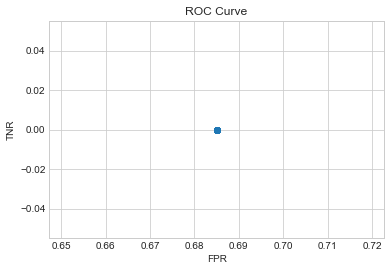

In [417]:
plot_ROC_curve(W, classification_test_X, classification_test_y)

#### 2.3.2

The quality of the optimal kernel SVM is poor since all the models predict the same value of 1 regardless of the hyperparamter value. There is no ROC curve observed.